# Uproot and Awkward Array tutorial

**July 6, 2021 at PyHEP**

<br><br><br><br><br>

## Z peak in PyROOT

Let's start with the most straightforward way to analyze HEP data in Python: "for" loops in PyROOT.

In [1]:
import time
import numpy as np
import ROOT

canvas = ROOT.TCanvas()

Welcome to JupyROOT 6.24/00


In [2]:
rootfile = ROOT.TFile.Open("data/HiggsZZ4mu.root")
roottree = rootfile.Get("Events")

In [3]:
starttime = time.time()

roothist = ROOT.TH1D("roothist", "mass", 120, 0, 120)

for index, event in enumerate(roottree):
    # cuts are "if" statements
    if event.nMuon >= 2 and event.Muon_charge[0] + event.Muon_charge[1] == 0:
        mu1_pt = event.Muon_pt[0]
        mu2_pt = event.Muon_pt[1]
        mu1_eta = event.Muon_eta[0]
        mu2_eta = event.Muon_eta[1]
        mu1_phi = event.Muon_phi[0]
        mu2_phi = event.Muon_phi[1]

        # histograms are filled in the loop
        roothist.Fill(
            np.sqrt(2*mu1_pt*mu2_pt*(np.cosh(mu1_eta - mu2_eta) - np.cos(mu1_phi - mu2_phi)))
        )

pyroot_time = time.time() - starttime
print(f"total time: {pyroot_time} sec")

total time: 20.115983724594116 sec


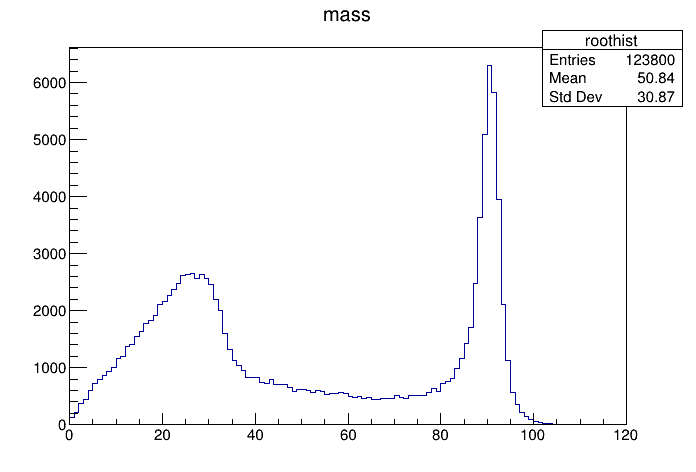

In [4]:
roothist.Draw()
canvas.Draw()

<br><br><br><br><br>

## Z peak in C++ ROOT

It works, but 20 seconds is a long time to wait for 1/8 million dimuons.

The traditional way to speed things up is to translate it into C++.

In [5]:
ROOT.gInterpreter.Declare('''
void compute(TH1D& roothist, TTree& roottree) {
    UInt_t nMuon;
    float Muon_pt[50];
    float Muon_eta[50];
    float Muon_phi[50];
    int32_t Muon_charge[50];

    roottree.SetBranchStatus("*", 0);
    roottree.SetBranchStatus("nMuon", 1);
    roottree.SetBranchStatus("Muon_pt", 1);
    roottree.SetBranchStatus("Muon_eta", 1);
    roottree.SetBranchStatus("Muon_phi", 1);
    roottree.SetBranchStatus("Muon_charge", 1);

    roottree.SetBranchAddress("nMuon", &nMuon);
    roottree.SetBranchAddress("Muon_pt", Muon_pt);
    roottree.SetBranchAddress("Muon_eta", Muon_eta);
    roottree.SetBranchAddress("Muon_phi", Muon_phi);
    roottree.SetBranchAddress("Muon_charge", Muon_charge);

    for (int index = 0; index < 100000; index++) {
        roottree.GetEntry(index);
        if (nMuon >= 2 && Muon_charge[0] + Muon_charge[1] == 0) {
            float mu1_pt = Muon_pt[0];
            float mu2_pt = Muon_pt[1];
            float mu1_eta = Muon_eta[0];
            float mu2_eta = Muon_eta[1];
            float mu1_phi = Muon_phi[0];
            float mu2_phi = Muon_phi[1];
            roothist.Fill(
                sqrt(2*mu1_pt*mu2_pt*(cosh(mu1_eta - mu2_eta) - cos(mu1_phi - mu2_phi)))
            );
        }
    }
}
''')

True

ROOT lets you compile a C++ function and run it through PyROOT.

The important thing here is that the _loop over events_ is in the compiled code.

In [6]:
starttime = time.time()

roothist2 = ROOT.TH1D("roothist2", "mass", 120, 0, 120)

ROOT.compute(roothist2, roottree)

cpproot_time = time.time() - starttime
print(f"total time: {cpproot_time} sec")

total time: 0.035388946533203125 sec


In [7]:
pyroot_time / cpproot_time

568.4256157701843

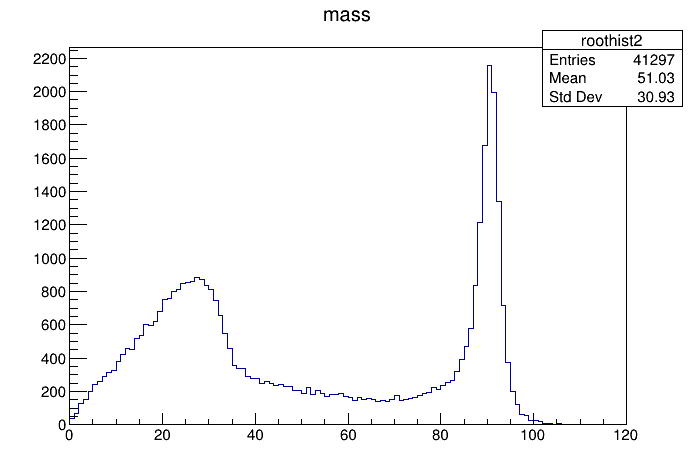

In [8]:
roothist2.Draw()
canvas.Draw()

<br><br><br><br><br>

## Z peak in RDataFrame

RDataFrame is the modern way to build workflows over HEP data in ROOT.

Each node in this pipeline is compiled in C++. The pipeline itself can be built in Python.

<img src="img/rdataframe-flow.svg" style="width: 800px">

In [9]:
df = ROOT.RDataFrame("Events", "data/HiggsZZ4mu.root")

# Each node is connected to the previous, in a chain (which can split and recombine).
df_2mu = df.Filter("nMuon >= 2")
df_os = df_2mu.Filter("Muon_charge[0] + Muon_charge[1] == 0")

# This node is a big C++ block.
df_mass = df_os.Define("Dimuon_mass", '''
float mu1_pt = Muon_pt[0];
float mu2_pt = Muon_pt[1];
float mu1_eta = Muon_eta[0];
float mu2_eta = Muon_eta[1];
float mu1_phi = Muon_phi[0];
float mu2_phi = Muon_phi[1];
return sqrt(2*mu1_pt*mu2_pt*(cosh(mu1_eta - mu2_eta) - cos(mu1_phi - mu2_phi)));
''')

roothist3 = df_mass.Histo1D(("h3", "mass", 120, 0, 120), "Dimuon_mass")

The calculation doesn't actually start until you attempt to look at a result (convert to NumPy or draw a plot).

In [10]:
starttime = time.time()

# This one is an endpoint (action).
array = df_mass.AsNumpy(["Dimuon_mass"])

rdfroot_time = time.time() - starttime
print(f"total time: {rdfroot_time} sec")

total time: 1.9240071773529053 sec


In [11]:
pyroot_time / rdfroot_time

10.455253993527283

In [12]:
array

{'Dimuon_mass': ndarray([36.91503 , 88.4434  , 22.870972, ..., 26.973433, 68.36317 ,
          68.305984], dtype=float32)}

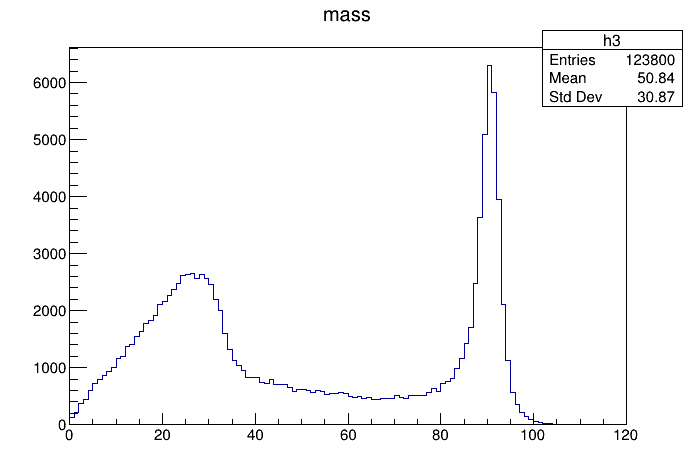

In [13]:
roothist3.Draw()
canvas.Draw()

<br><br><br><br><br>

## Uproot and Awkward Array

Uproot's approach is different: each Python command operates on a whole array at a time (like NumPy).

Loops over all events happen in compiled code, but you don't write that code—you combine primitives to build a workflow.

In [14]:
import awkward as ak
import uproot
import hist

Open a file and look at its contents.

In [15]:
events = uproot.open("data/HiggsZZ4mu.root:Events")
events.show()

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
run                  | int32_t                  | AsDtype('>i4')
luminosityBlock      | uint32_t                 | AsDtype('>u4')
event                | uint64_t                 | AsDtype('>u8')
nMuon                | uint32_t                 | AsDtype('>u4')
Muon_pt              | float[]                  | AsJagged(AsDtype('>f4'))
Muon_eta             | float[]                  | AsJagged(AsDtype('>f4'))
Muon_phi             | float[]                  | AsJagged(AsDtype('>f4'))
Muon_mass            | float[]                  | AsJagged(AsDtype('>f4'))
Muon_charge          | int32_t[]                | AsJagged(AsDtype('>i4'))
MET_pt               | float                    | AsDtype('>f4')
MET_phi              | float                    | AsDtype('>f4')
nGenPart             | uint32_t                 | AsDtype('>u4')
GenPart_

Extract some branches as an "array of records" (renaming the fields).

In [16]:
muons = events.arrays(
    ["pt", "eta", "phi", "charge"],
    aliases={"pt": "Muon_pt", "eta": "Muon_eta", "phi": "Muon_phi", "charge": "Muon_charge"}
)
muons

<Array [{pt: [], eta: [], ... -1, 1, -1]}] type='299683 * {"pt": var * float32, ...'>

In [17]:
muons.fields

['pt', 'eta', 'phi', 'charge']

A cut is an array of booleans, which we can construct as a formula.

In [18]:
cut = (ak.num(muons.charge) >= 2) & (ak.sum(muons.charge[:, :2], axis=1) == 0)
cut

<Array [False, True, False, ... True, True] type='299683 * bool'>

Applying a cut is a slice. In the same slice, we can pick the first (`0`) and second (`1`) muon in each event.

In [19]:
mu1 = muons[cut, 0]
mu2 = muons[cut, 1]
mu1, mu2

(<Array [{pt: 18.6, eta: -0.179, ... charge: 1}] type='123800 * {"pt": float32, "...'>,
 <Array [{pt: 23.6, eta: 0.224, ... charge: -1}] type='123800 * {"pt": float32, "...'>)

Let's use the [hist](https://github.com/scikit-hep/hist#readme) library for histograms.

In [20]:
h = hist.Hist.new.Reg(120, 0, 120, name="mass").Double()
h

Hist(Regular(120, 0, 120, name='mass', label='mass'), storage=Double())

In [21]:
h.fill(np.sqrt(2*mu1.pt*mu2.pt*(np.cosh(mu1.eta - mu2.eta) - np.cos(mu1.phi - mu2.phi))))

Hist(Regular(120, 0, 120, name='mass', label='mass'), storage=Double()) # Sum: 123753.0 (123800.0 with flow)

And Matplotlib for plots.

In [22]:
import matplotlib.pyplot as plt

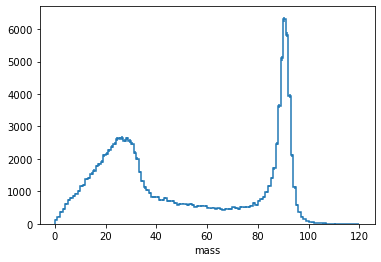

In [23]:
h.plot();

<br><br><br><br><br>

Now let's do the whole thing in one cell and time it.

In [24]:
starttime = time.time()

# read data
muons = events.arrays(
    ["pt", "eta", "phi", "charge"],
    aliases={"pt": "Muon_pt", "eta": "Muon_eta", "phi": "Muon_phi", "charge": "Muon_charge"},
    array_cache=None,   # no cheating!
)

# compute
cut = (ak.num(muons.charge) >= 2) & (ak.sum(muons.charge[:, :2], axis=1) == 0)
mu1 = muons[cut, 0]
mu2 = muons[cut, 1]
h = hist.Hist.new.Reg(120, 0, 120, name="mass").Double()
h.fill(np.sqrt(2*mu1.pt*mu2.pt*(np.cosh(mu1.eta - mu2.eta) - np.cos(mu1.phi - mu2.phi))))

uproot_time = time.time() - starttime
print(f"total time: {uproot_time} sec")

total time: 0.07280492782592773 sec


In [25]:
pyroot_time / uproot_time

276.2997550480407

It's in the same ballpark as C++. It can be 1.5× to 2× slower, but it's much closer to C++ on a log plot than it is to Python "for" loops.

<br><br><br><br><br>

## The Pythonic HEP ecosystem

Uproot is not a framework, it _only_ does ROOT I/O. Awkward Array handles array manipulation, hist does histograms, etc.

It is part of this complete breakfast:

<img src="img/logo-parade.svg" width="800px">

<br><br><br><br><br>

## Uproot

Uproot is an independent implementation of ROOT I/O that leverages standard Python libraries.

<img src="img/abstraction-layers.svg" width="800px">

<br><br><br><br><br>

The documentation is at [https://uproot.readthedocs.io/](https://uproot.readthedocs.io/).

<img src="img/uproot-documentation.png" width="800px"/>

<br><br><br><br><br>

## Navigating a ROOT file

<img src="img/terminology.svg" style="width: 800px">

In [26]:
histograms = uproot.open("data/HiggsZZ4mu_histograms.root")
histograms

<ReadOnlyDirectory '/' at 0x7f1414f70c70>

In [27]:
histograms.file

<ReadOnlyFile 'data/HiggsZZ4mu_histograms.root' at 0x7f1414f6c5b0>

In Uproot, a directory is a dict-like object with subscripting (square brackets), [keys](https://uproot.readthedocs.io/en/latest/uproot.reading.ReadOnlyDirectory.html#keys), [values](https://uproot.readthedocs.io/en/latest/uproot.reading.ReadOnlyDirectory.html#values), [items](https://uproot.readthedocs.io/en/latest/uproot.reading.ReadOnlyDirectory.html#items), and [classnames](https://uproot.readthedocs.io/en/latest/uproot.reading.ReadOnlyDirectory.html#classnames) methods.

In [28]:
histograms["Z"]

<ReadOnlyDirectory '/Z' at 0x7f1414f6c3d0>

In [29]:
histograms["Z"]["4mu"]

<ReadOnlyDirectory '/Z/4mu' at 0x7f1414f6cbb0>

Try `recursive`, `filter_name`, and `filter_classname` arguments.

In [30]:
histograms.keys()

['num;1',
 'num/NGMuons;1',
 'num/NMuons;1',
 'num/Nelectrons;1',
 'num/NGoodGMuons;1',
 'num/NGoodRecMuons;1',
 'num/NGoodElectron;1',
 'Z;1',
 'Z/all;1',
 'Z/all/GMmass;1',
 'Z/all/GMmass_extended;1',
 'Z/all/GMmass_extended_600;1',
 'Z/all/massZto2muon;1',
 'Z/all/massZto2e;1',
 'Z/4mu;1',
 'Z/4mu/by_pt;1',
 'Z/4mu/by_pt/mZ12_4mu;1',
 'Z/4mu/by_pt/mZ34_4mu;1',
 'Z/4mu/by_pt/mZ13_4mu;1',
 'Z/4mu/by_pt/mZ24_4mu;1',
 'Z/4mu/by_pt/mZ14_4mu;1',
 'Z/4mu/by_pt/mZ23_4mu;1',
 'Z/4mu/by_mass;1',
 'Z/4mu/by_mass/mZa_4mu;1',
 'Z/4mu/by_mass/mZb_4mu;1',
 'Z/4e;1',
 'Z/4e/by_pt;1',
 'Z/4e/by_pt/mZ12_4e;1',
 'Z/4e/by_pt/mZ34_4e;1',
 'Z/4e/by_pt/mZ13_4e;1',
 'Z/4e/by_pt/mZ24_4e;1',
 'Z/4e/by_pt/mZ14_4e;1',
 'Z/4e/by_pt/mZ23_4e;1',
 'Z/4e/by_mass;1',
 'Z/4e/by_mass/mZa_4e;1',
 'Z/4e/by_mass/mZb_4e;1',
 'Z/2mu2e;1',
 'Z/2mu2e/massZmu_2mu2e;1',
 'Z/2mu2e/massZe_2mu2e;1',
 'H;1',
 'H/4mu;1',
 'H/4mu/mass4mu_7TeV;1',
 'H/4mu/mass4mu_8TeV;1',
 'H/4mu/mass4mu_8TeV_low;1',
 'H/4mu/mass4mu_full;1',
 'H/4e;1

Most histograms and graphs can be converted to types in other Python libraries.

Try the `to_hist()` method on this one.

In [31]:
histograms["Z/all/massZto2muon"]

<TH1D (version 3) at 0x7f1414f66a60>

<br><br><br>

**Three-minute exercise:** find the 2D histogram and plot it.

In [32]:
histograms

<ReadOnlyDirectory '/' at 0x7f1414f70c70>

<br><br><br><br><br>

## Can Uproot read my data?

<img src="img/can-uproot-read-it.svg" width="500px"/>

Here is a file with analysis-specific classes; Uproot _cannot_ have prior knowledge of these classes.

In [33]:
icecube = uproot.open("data/icecube-supernovae.root")
icecube.keys()

['config;1',
 'config/analysis;1',
 'config/detector;1',
 'config/run;1',
 'sn_all;1',
 'sn_gps;1',
 'sn_range;1',
 'sn_o2rout;1',
 'sn_o2cand;1',
 'sn_omwatch;1',
 'sn_sigsim;1']

In [34]:
icecube.classname_of("config/detector")

'I3Eval_t'

It is possible to read an `I3Eval_t` object because ROOT stores the "how to read" instructions in the file (called "streamers").

In [35]:
icecube.file.show_streamers("I3Eval_t")

I3Eval_t::ChannelContainer_t (v1)

Sni3DataArray (v1)

TObject (v1)
    fUniqueID: unsigned int (TStreamerBasicType)
    fBits: unsigned int (TStreamerBasicType)

I3Eval_t (v7): TObject (v1)
    theDataArray: Sni3DataArray* (TStreamerObjectAnyPointer)
    NumberOfChannels: int (TStreamerBasicType)
    NoAvailableSlices: int (TStreamerBasicType)
    AvailableDataSize: int (TStreamerBasicType)
    mGPSCardId: int (TStreamerBasicType)
    mGPSPrescale: int (TStreamerBasicType)
    mGPSEventNo: int (TStreamerBasicType)
    mScalerCardId: int (TStreamerBasicType)
    mScalerStartChannel: int (TStreamerBasicType)
    StartUTC: long (TStreamerBasicType)
    MaxChannels: int (TStreamerBasicType)
    mMaxJitterLogs: int (TStreamerBasicType)
    Channel: I3Eval_t::ChannelContainer_t* (TStreamerObjectAnyPointer)
    ChannelIDMap: map<long,int> (TStreamerSTL)
    BadChannelIDSet: set<long> (TStreamerSTL)
    ChannelID: long* (TStreamerBasicPointer)
    Deadtime: double* (TStreamerBasicPointer)
   

In [36]:
icecube["config/detector"]

<I3Eval_t (version 7) at 0x7f1414f0c100>

In [37]:
icecube["config/detector"].all_members

{'@fUniqueID': 0,
 '@fBits': 50331648,
 'theDataArray': <Sni3DataArray (version 1) at 0x7f1414bfac40>,
 'NumberOfChannels': 5160,
 'NoAvailableSlices': -1,
 'AvailableDataSize': 0,
 'mGPSCardId': 0,
 'mGPSPrescale': 20000000,
 'mGPSEventNo': 92824,
 'mScalerCardId': 0,
 'mScalerStartChannel': 0,
 'StartUTC': 272924620173109013,
 'MaxChannels': 5160,
 'mMaxJitterLogs': 20,
 'Channel': <I3Eval_t::ChannelContainer_t (version 1) at 0x7f1414bfae50>,
 'ChannelIDMap': <STLMap {46612627560: 896, ..., 281410180683757: 2689} at 0x7f1414ae50d0>,
 'BadChannelIDSet': <STLSet {58348614635591, 60068372029697, ..., 258905191174588} at 0x7f1414ae5130>,
 'ChannelID': array([ 47303335284587,  20579555797555, 106634453247646, ...,
        255380957221937, 107432791511293, 280205879548048]),
 'Deadtime': array([250., 250., 250., ..., 250., 250., 250.]),
 'Efficiency': array([1.  , 1.  , 1.  , ..., 1.35, 1.35, 1.35])}

In [38]:
icecube["config/detector"].member("ChannelIDMap")

<STLMap {46612627560: 896, ..., 281410180683757: 2689} at 0x7f1414ae50d0>

Unlike histograms, these objects have no methods to help you unpack the data; it's all in [members](https://uproot.readthedocs.io/en/latest/uproot.model.Model.html#members), [all_members](https://uproot.readthedocs.io/en/latest/uproot.model.Model.html#all-members), [has_member](https://uproot.readthedocs.io/en/latest/uproot.model.Model.html#has-member), and [member](https://uproot.readthedocs.io/en/latest/uproot.model.Model.html#member).

<br><br><br><br><br>

## Navigating TTrees

In [39]:
zmumu_file = uproot.open("data/Zmumu.root")
zmumu_file.classnames()

{'events;1': 'TTree'}

Often, the best thing to do first with an unfamiliar TTree is [show](https://uproot.readthedocs.io/en/latest/uproot.behaviors.TTree.TTree.html#show).

In [40]:
zmumu = zmumu_file["events"]
zmumu.show()

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
Type                 | char*                    | AsStrings()
Run                  | int32_t                  | AsDtype('>i4')
Event                | int32_t                  | AsDtype('>i4')
E1                   | double                   | AsDtype('>f8')
px1                  | double                   | AsDtype('>f8')
py1                  | double                   | AsDtype('>f8')
pz1                  | double                   | AsDtype('>f8')
pt1                  | double                   | AsDtype('>f8')
eta1                 | double                   | AsDtype('>f8')
phi1                 | double                   | AsDtype('>f8')
Q1                   | int32_t                  | AsDtype('>i4')
E2                   | double                   | AsDtype('>f8')
px2                  | double                   | AsDtype('>f

Keep in mind that

   * TTrees are dict-like objects with subscripting (square brackets), [keys](https://uproot.readthedocs.io/en/latest/uproot.behaviors.TTree.TTree.html#keys), [values](https://uproot.readthedocs.io/en/latest/uproot.behaviors.TTree.TTree.html#values), [items](https://uproot.readthedocs.io/en/latest/uproot.behaviors.TTree.TTree.html#items), and [typenames](https://uproot.readthedocs.io/en/latest/uproot.behaviors.TTree.TTree.html#typenames) methods (like directories)
   * you can access all of the above data with methods: you don't have to parse the [show](https://uproot.readthedocs.io/en/latest/uproot.behaviors.TTree.TTree.html#show) string!

In [41]:
zmumu.keys()

['Type',
 'Run',
 'Event',
 'E1',
 'px1',
 'py1',
 'pz1',
 'pt1',
 'eta1',
 'phi1',
 'Q1',
 'E2',
 'px2',
 'py2',
 'pz2',
 'pt2',
 'eta2',
 'phi2',
 'Q2',
 'M']

In [42]:
zmumu.typenames()

{'Type': 'char*',
 'Run': 'int32_t',
 'Event': 'int32_t',
 'E1': 'double',
 'px1': 'double',
 'py1': 'double',
 'pz1': 'double',
 'pt1': 'double',
 'eta1': 'double',
 'phi1': 'double',
 'Q1': 'int32_t',
 'E2': 'double',
 'px2': 'double',
 'py2': 'double',
 'pz2': 'double',
 'pt2': 'double',
 'eta2': 'double',
 'phi2': 'double',
 'Q2': 'int32_t',
 'M': 'double'}

In [43]:
{name: branch.interpretation for name, branch in zmumu.items()}

{'Type': AsStrings(),
 'Run': AsDtype('>i4'),
 'Event': AsDtype('>i4'),
 'E1': AsDtype('>f8'),
 'px1': AsDtype('>f8'),
 'py1': AsDtype('>f8'),
 'pz1': AsDtype('>f8'),
 'pt1': AsDtype('>f8'),
 'eta1': AsDtype('>f8'),
 'phi1': AsDtype('>f8'),
 'Q1': AsDtype('>i4'),
 'E2': AsDtype('>f8'),
 'px2': AsDtype('>f8'),
 'py2': AsDtype('>f8'),
 'pz2': AsDtype('>f8'),
 'pt2': AsDtype('>f8'),
 'eta2': AsDtype('>f8'),
 'phi2': AsDtype('>f8'),
 'Q2': AsDtype('>i4'),
 'M': AsDtype('>f8')}

<br><br><br><br><br>

## Reading TBranches into arrays

The basic method is to get a TBranch (with square brackets) and call [array](https://uproot.readthedocs.io/en/latest/uproot.behaviors.TBranch.TBranch.html#array).

In [44]:
zmumu["M"].array()

<Array [82.5, 83.6, 83.3, ... 96, 96.5, 96.7] type='2304 * float64'>

Some important parameters:

   * `entry_start`, `entry_stop` to limit how much you read (if it's big)
   * `library="np"` for NumPy arrays, `library="ak"` for Awkward Arrays, and `library="pd"` for Pandas (Series or DataFrame)

In [45]:
zmumu["M"].array(entry_stop=5)

<Array [82.5, 83.6, 83.3, 82.1, 90.5] type='5 * float64'>

Get a NumPy (not Awkward) array:

In [46]:
zmumu["M"].array(library="np")

array([82.46269156, 83.62620401, 83.30846467, ..., 95.96547966,
       96.49594381, 96.65672765])

Get a Pandas Series:

In [47]:
zmumu["M"].array(library="pd")

0       82.462692
1       83.626204
2       83.308465
3       82.149373
4       90.469123
          ...    
2299    60.047138
2300    96.125376
2301    95.965480
2302    96.495944
2303    96.656728
Length: 2304, dtype: float64

<br><br><br><br><br>

## Reading many arrays at once

The [arrays](https://uproot.readthedocs.io/en/latest/uproot.behaviors.TBranch.HasBranches.html#arrays) method retrieves many TBranches into a "group" of arrays.

What a "group" means depends on the library.

Awkward Arrays group data in records (substructure within the array).

In [48]:
zmumu.arrays()

<Array [{Type: 'GT', Run: 148031, ... M: 96.7}] type='2304 * {"Type": string, "R...'>

A "group" of NumPy arrays is a dict (unless you specify `how`):

In [49]:
zmumu.arrays(library="np")

{'Type': array(['GT', 'TT', 'GT', ..., 'TT', 'GT', 'GG'], dtype=object),
 'Run': array([148031, 148031, 148031, ..., 148029, 148029, 148029], dtype=int32),
 'Event': array([10507008, 10507008, 10507008, ..., 99991333, 99991333, 99991333],
       dtype=int32),
 'E1': array([82.20186639, 62.34492895, 62.34492895, ..., 81.27013558,
        81.27013558, 81.56621735]),
 'px1': array([-41.19528764,  35.11804977,  35.11804977, ...,  32.37749196,
         32.37749196,  32.48539387]),
 'py1': array([ 17.4332439 , -16.57036233, -16.57036233, ...,   1.19940578,
          1.19940578,   1.2013503 ]),
 'pz1': array([-68.96496181, -48.77524654, -48.77524654, ..., -74.53243061,
        -74.53243061, -74.80837247]),
 'pt1': array([44.7322, 38.8311, 38.8311, ..., 32.3997, 32.3997, 32.3997]),
 'eta1': array([-1.21769, -1.05139, -1.05139, ..., -1.57044, -1.57044, -1.57044]),
 'phi1': array([ 2.74126  , -0.440873 , -0.440873 , ...,  0.0370275,  0.0370275,
         0.0370275]),
 'Q1': array([ 1, -1, -1, ...

A "group" of Pandas Series is a DataFrame:

In [50]:
zmumu.arrays(library="pd")

,Type,Run,Event,E1,px1,py1,pz1,pt1,eta1,phi1,Q1,E2,px2,py2,pz2,pt2,eta2,phi2,Q2,M
0,GT,148031,10507008,82.201866,-41.195288,17.433244,-68.964962,44.7322,-1.217690,2.741260,1,60.621875,34.144437,-16.119525,-47.426984,38.8311,-1.051390,-0.440873,-1,82.462692
1,TT,148031,10507008,62.344929,35.118050,-16.570362,-48.775247,38.8311,-1.051390,-0.440873,-1,82.201866,-41.195288,17.433244,-68.964962,44.7322,-1.217690,2.741260,1,83.626204
2,GT,148031,10507008,62.344929,35.118050,-16.570362,-48.775247,38.8311,-1.051390,-0.440873,-1,81.582778,-40.883323,17.299297,-68.447255,44.7322,-1.217690,2.741260,1,83.308465
3,GG,148031,10507008,60.621875,34.144437,-16.119525,-47.426984,38.8311,-1.051390,-0.440873,-1,81.582778,-40.883323,17.299297,-68.447255,44.7322,-1.217690,2.741260,1,82.149373
4,GT,148031,105238546,41.826389,22.783582,15.036444,-31.689894,27.2981,-0.990688,0.583351,1,49.760726,-20.177373,-9.354149,44.513955,21.8913,1.444340,-2.707650,-1,90.469123
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2299,GG,148029,99768888,32.701650,19.054651,14.833954,22.051323,24.1264,0.818806,0.661492,1,27.714554,-16.874052,-15.319644,-15.768964,22.8145,-0.645971,-2.404430,-1,60.047138
2300,GT,148029,99991333,168.780121,-68.041915,-26.105847,-152.235018,72.8781,-1.482700,-2.775240,-1,81.566217,32.485394,1.201350,-74.808372,32.3997,-1.570440,0.037027,1,96.125376
2301,TT,148029,99991333,81.270136,32.377492,1.199406,-74.532431,32.3997,-1.570440,0.037027,1,168.780121,-68.041915,-26.105847,-152.235018,72.8781,-1.482700,-2.775240,-1,95.965480
2302,GT,148029,99991333,81.270136,32.377492,1.199406,-74.532431,32.3997,-1.570440,0.037027,1,170.583132,-68.794136,-26.398400,-153.847604,72.8781,-1.482700,-2.775240,-1,96.495944


The first argument can be used to extract TBranches by name:

In [51]:
zmumu.arrays(["px1", "py1", "px2", "py2"], library="pd")

,px1,py1,px2,py2
0,-41.195288,17.433244,34.144437,-16.119525
1,35.118050,-16.570362,-41.195288,17.433244
2,35.118050,-16.570362,-40.883323,17.299297
3,34.144437,-16.119525,-40.883323,17.299297
4,22.783582,15.036444,-20.177373,-9.354149
...,...,...,...,...
2299,19.054651,14.833954,-16.874052,-15.319644
2300,-68.041915,-26.105847,32.485394,1.201350
2301,32.377492,1.199406,-68.041915,-26.105847
2302,32.377492,1.199406,-68.794136,-26.398400


But this argument actually takes arbitrary (Python) expressions.

In [52]:
zmumu.arrays(["sqrt(px1**2 + py1**2)", "sqrt(px2**2 + py2**2)"], library="pd")

,sqrt(px1**2 + py1**2),sqrt(px2**2 + py2**2)
0,44.7322,37.7582
1,38.8311,44.7322
2,38.8311,44.3927
3,37.7582,44.3927
4,27.2981,22.2402
...,...,...
2299,24.1480,22.7909
2300,72.8781,32.5076
2301,32.3997,72.8781
2302,32.3997,73.6852


This is to support any [aliases](https://uproot.readthedocs.io/en/latest/uproot.behaviors.TTree.TTree.html#aliases) that might be in the [TTree](https://uproot.readthedocs.io/en/latest/uproot.behaviors.TTree.TTree.html), but you can make up your own `aliases` on the spot.

In [53]:
zmumu.arrays(
    ["pt1", "pt2"],
    {"pt1": "sqrt(px1**2 + py1**2)", "pt2": "sqrt(px2**2 + py2**2)"},
    library="pd",
)

,pt1,pt2
0,44.7322,38.8311
1,38.8311,44.7322
2,38.8311,44.7322
3,38.8311,44.7322
4,27.2981,21.8913
...,...,...
2299,24.1264,22.8145
2300,72.8781,32.3997
2301,32.3997,72.8781
2302,32.3997,72.8781


The fact that these are interpreted as expressions has some "gotchas":

   * nested branches, paths with "`/`", _would be interpreted as division!_
   * wildcards, paths with "`*`", _would be interpreted as multiplication!_

For pattern-matching on TBranches, use the `filter_name`, `filter_typename`, and `filter_branch` arguments of [arrays](https://uproot.readthedocs.io/en/latest/uproot.behaviors.TBranch.HasBranches.html#arrays).

In [54]:
zmumu.arrays(filter_name="p[xyz]*", library="pd")

,px1,py1,pz1,px2,py2,pz2
0,-41.195288,17.433244,-68.964962,34.144437,-16.119525,-47.426984
1,35.118050,-16.570362,-48.775247,-41.195288,17.433244,-68.964962
2,35.118050,-16.570362,-48.775247,-40.883323,17.299297,-68.447255
3,34.144437,-16.119525,-47.426984,-40.883323,17.299297,-68.447255
4,22.783582,15.036444,-31.689894,-20.177373,-9.354149,44.513955
...,...,...,...,...,...,...
2299,19.054651,14.833954,22.051323,-16.874052,-15.319644,-15.768964
2300,-68.041915,-26.105847,-152.235018,32.485394,1.201350,-74.808372
2301,32.377492,1.199406,-74.532431,-68.041915,-26.105847,-152.235018
2302,32.377492,1.199406,-74.532431,-68.794136,-26.398400,-153.847604


These filters have the same meaning as in [keys](https://uproot.readthedocs.io/en/latest/uproot.behaviors.TBranch.HasBranches.html#keys) and [typenames](https://uproot.readthedocs.io/en/latest/uproot.behaviors.TBranch.HasBranches.html#typenames), so you can test your filters without reading data.

In [55]:
zmumu.keys(filter_name="p[xyz]*")

['px1', 'py1', 'pz1', 'px2', 'py2', 'pz2']

In [56]:
zmumu.typenames(filter_name="p[xyz]*")

{'px1': 'double',
 'py1': 'double',
 'pz1': 'double',
 'px2': 'double',
 'py2': 'double',
 'pz2': 'double'}

<br><br><br>

### Get arrays in manageable chunks

The [iterate](https://uproot.readthedocs.io/en/latest/uproot.behaviors.TBranch.HasBranches.html#iterate) method is like [arrays](https://uproot.readthedocs.io/en/latest/uproot.behaviors.TBranch.HasBranches.html#arrays), but it can be used in a loop over chunks of the array.

How large are the chunks? You should set that with `step_size`.

In [57]:
for arrays in zmumu.iterate(step_size=300):
    print(repr(arrays))

<Array [{Type: 'GT', Run: 148031, ... M: 91.2}] type='300 * {"Type": string, "Ru...'>
<Array [{Type: 'GT', Run: 148031, ... M: 93.6}] type='300 * {"Type": string, "Ru...'>
<Array [{Type: 'GT', Run: 148031, ... M: 91.8}] type='300 * {"Type": string, "Ru...'>
<Array [{Type: 'TT', Run: 148031, ... M: 94.2}] type='300 * {"Type": string, "Ru...'>
<Array [{Type: 'TT', Run: 148031, ... M: 92.9}] type='300 * {"Type": string, "Ru...'>
<Array [{Type: 'GT', Run: 148031, ... M: 87.7}] type='300 * {"Type": string, "Ru...'>
<Array [{Type: 'TT', Run: 148029, ... M: 81.1}] type='300 * {"Type": string, "Ru...'>
<Array [{Type: 'TT', Run: 148029, ... M: 96.7}] type='204 * {"Type": string, "Ru...'>


In [58]:
for arrays in zmumu.iterate(step_size="50 kB"):   # 50 kB is very small! for illustrative purposes only!
    print(repr(arrays))

<Array [{Type: 'GT', Run: 148031, ... M: 89.6}] type='667 * {"Type": string, "Ru...'>
<Array [{Type: 'TT', Run: 148031, ... M: 18.1}] type='667 * {"Type": string, "Ru...'>
<Array [{Type: 'GT', Run: 148031, ... M: 94.7}] type='667 * {"Type": string, "Ru...'>
<Array [{Type: 'GT', Run: 148029, ... M: 96.7}] type='303 * {"Type": string, "Ru...'>


<br><br><br>

### Collections of files (like TChain)

Each of the single-TTree array-reading methods has a corresponding multi-file function.

   * The equivalent of TTree [arrays](https://uproot.readthedocs.io/en/latest/uproot.behaviors.TTree.TTree.html#arrays) is [uproot.concatenate](https://uproot.readthedocs.io/en/latest/uproot.behaviors.TBranch.concatenate.html). _(Reads everything at once: use this as a convenience on datasets you know are small!)_
   * The equivalent of TTree [iterate](https://uproot.readthedocs.io/en/latest/uproot.behaviors.TTree.TTree.html#iterate) is [uproot.iterate](https://uproot.readthedocs.io/en/latest/uproot.behaviors.TBranch.iterate.html). _(This is the most useful one.)_
   * There's also an [uproot.lazy](https://uproot.readthedocs.io/en/latest/uproot.behaviors.TBranch.lazy.html) _(More on this below.)_

Demo of scanning through a large (remote) file:

In [59]:
import IPython
import matplotlib.pyplot as plt
import matplotlib.pylab

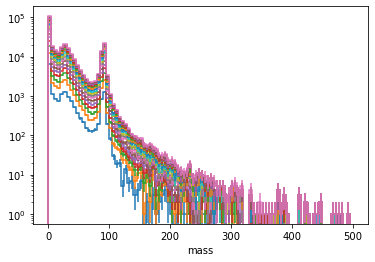

In [60]:
h = hist.Hist.new.Reg(100, 0, 500, name="mass").Double()

for muons in uproot.iterate(
    # filename(s)
    ["root://eospublic.cern.ch//eos/opendata/cms/derived-data/AOD2NanoAODOutreachTool/Run2012BC_DoubleMuParked_Muons.root:Events"],

    # expressions
    ["pt", "eta", "phi", "charge"],
    aliases={"pt": "Muon_pt", "eta": "Muon_eta", "phi": "Muon_phi", "charge": "Muon_charge"},    

    # the all-important step_size!
    step_size="1 MB",
):
    # do everything you're going to do to this array
    cut = (ak.num(muons.charge) >= 2) & (ak.sum(muons.charge[:, :2], axis=1) == 0)
    mu1 = muons[cut, 0]
    mu2 = muons[cut, 1]

    # such as filling a histogram
    h.fill(np.sqrt(2*mu1.pt*mu2.pt*(np.cosh(mu1.eta - mu2.eta) - np.cos(mu1.phi - mu2.phi))))

    h.plot()
    plt.yscale("log")
    IPython.display.display(matplotlib.pylab.gcf())
    IPython.display.clear_output(wait=True)

    if h.counts().sum() > 300000:
        break

<br><br><br><br><br>

Lazy reading is like iterative reading, but it fetches the data only when needed.

In [61]:
lazy = uproot.lazy(
    # filename(s)
    ["root://eospublic.cern.ch//eos/opendata/cms/derived-data/AOD2NanoAODOutreachTool/Run2012BC_DoubleMuParked_Muons.root:Events"],
    # step_size is still important
    step_size="1 MB",
)
lazy

<Array [{nMuon: 2, Muon_pt: [10.8, ... -1, 1]}] type='61540413 * {"nMuon": uint3...'>

In [62]:
lazy.Muon_pt

<Array [[10.8, 15.7], [10.5, ... [27.7, 20]] type='61540413 * var * float32'>

In [63]:
lazy.Muon_eta

<Array [[1.07, -0.564], ... [-2.15, 0.291]] type='61540413 * var * float32'>

**Important:** this is not the most efficient way to iterate through a file when you _know_ which TBranches you want to read.

It exists for interactive exploration.

<br><br><br><br><br>

## What if the data are not one-dimensional or rectilinear arrays?

Consider this ROOT file (simulation used in the Higgs discovery, converted to NanoAOD).

In [64]:
events = uproot.open("data/HiggsZZ4mu.root:Events")

Some data, such as missing energy (MET), consist of a single value per collision event and can be represented by normal NumPy arrays.

In [65]:
nonjagged = events["MET_pt"].array(entry_stop=20, library="np")
nonjagged

array([19.49629  , 20.397919 , 28.817572 ,  4.415469 ,  5.8566523,
       19.178032 ,  5.859101 , 45.975037 , 26.793552 , 23.152561 ,
        8.993562 , 11.69979  , 22.774422 , 56.671833 ,  9.606522 ,
       13.729865 , 26.599598 , 21.974018 , 16.044271 ,  8.862462 ],
      dtype=float32)

Normal NumPy slicing rules apply.

In [66]:
nonjagged[:5]

array([19.49629  , 20.397919 , 28.817572 ,  4.415469 ,  5.8566523],
      dtype=float32)

<br><br><br><br><br>

Some data cannot. There's a different number of muons in each event, so we need variable-length nested lists to represent their transverse momenta ($p_T$).

In [67]:
jagged_awkward = events["Muon_pt"].array(entry_stop=20)
jagged_awkward

<Array [[], [18.6, 23.6], ... [13.6, 5.43]] type='20 * var * float32'>

In [68]:
jagged_awkward.tolist()

[[],
 [18.583789825439453, 23.630338668823242],
 [],
 [26.678863525390625, 21.356121063232422, 5.6486287117004395],
 [7.621268272399902],
 [6.581045150756836],
 [],
 [],
 [8.512704849243164],
 [8.245718955993652, 23.482236862182617],
 [40.31018829345703, 21.819368362426758],
 [41.209922790527344, 10.689908981323242, 43.4166145324707],
 [],
 [],
 [15.671303749084473, 82.08026123046875, 19.20456314086914, 8.81103515625],
 [28.460538864135742, 25.13064956665039],
 [42.40679931640625, 109.85435485839844],
 [102.75817108154297,
  87.80870819091797,
  13.76916790008545,
  33.045799255371094,
  27.982389450073242,
  27.750789642333984],
 [9.967660903930664, 13.108595848083496],
 [13.59410285949707, 5.430370330810547]]

It is _possible_ to read these data into NumPy, but with a considerable cost.

In [69]:
jagged_numpy = events["Muon_pt"].array(entry_stop=20, library="np")
jagged_numpy

array([array([], dtype=float32),
       array([18.58379 , 23.630339], dtype=float32),
       array([], dtype=float32),
       array([26.678864 , 21.356121 ,  5.6486287], dtype=float32),
       array([7.6212683], dtype=float32),
       array([6.581045], dtype=float32), array([], dtype=float32),
       array([], dtype=float32), array([8.512705], dtype=float32),
       array([ 8.245719, 23.482237], dtype=float32),
       array([40.31019 , 21.819368], dtype=float32),
       array([41.209923, 10.689909, 43.416615], dtype=float32),
       array([], dtype=float32), array([], dtype=float32),
       array([15.671304, 82.08026 , 19.204563,  8.811035], dtype=float32),
       array([28.460539, 25.13065 ], dtype=float32),
       array([ 42.4068  , 109.854355], dtype=float32),
       array([102.75817 ,  87.80871 ,  13.769168,  33.0458  ,  27.98239 ,
               27.75079 ], dtype=float32)                                ,
       array([ 9.967661, 13.108596], dtype=float32),
       array([13.594103 

This is an _array of NumPy arrays_ (because you can put Python objects in NumPy arrays—not recommended).

You might want to consider the inner arrays to be a second dimension and use normal slicing rules:

In [70]:
jagged_awkward[:, :1]

<Array [[], [18.6], [], ... [9.97], [13.6]] type='20 * var * float32'>

In [71]:
jagged_numpy[:, :1]

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In NumPy, you can't. NumPy doesn't know that all the contents of this array are arrays of the same type.

You know this and can write a loop in Python:

In [72]:
np.array([x[:1] for x in jagged_numpy])

<ipython-input-72-d148b00ddeec>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array([x[:1] for x in jagged_numpy])


array([array([], dtype=float32), array([18.58379], dtype=float32),
       array([], dtype=float32), array([26.678864], dtype=float32),
       array([7.6212683], dtype=float32),
       array([6.581045], dtype=float32), array([], dtype=float32),
       array([], dtype=float32), array([8.512705], dtype=float32),
       array([8.245719], dtype=float32), array([40.31019], dtype=float32),
       array([41.209923], dtype=float32), array([], dtype=float32),
       array([], dtype=float32), array([15.671304], dtype=float32),
       array([28.460539], dtype=float32), array([42.4068], dtype=float32),
       array([102.75817], dtype=float32),
       array([9.967661], dtype=float32),
       array([13.594103], dtype=float32)], dtype=object)

But this isn't recommended. It's non-idiomatic and slow.

<br><br><br><br><br>

Pandas can work with this "jagged" data through indexing.

In [73]:
events.arrays(filter_name=["Muon_*"], library="pd")

Muon_pt  Muon_eta  Muon_phi  Muon_mass  Muon_charge
entry  subentry                                                       
1      0         18.583790 -0.178740  2.129222   0.105658            1
       1         23.630339  0.224128 -2.094648   0.105658           -1
3      0         26.678864 -1.230025 -1.394925   0.105658           -1
       1         21.356121  1.266814  1.025966   0.105658            1
       2          5.648629  0.879901  0.078487   0.105658            1
...                    ...       ...       ...        ...          ...
299681 2         16.299486 -0.852460  1.028339   0.105658            1
299682 0         30.407604  1.319252  0.139041   0.105658            1
       1         36.361153  0.763660 -2.690076   0.105658           -1
       2         19.553925  0.728021 -0.375699   0.105658            1
       3         22.570639 -0.233684  2.841248   0.105658           -1

[423743 rows x 5 columns]

But there are limitations. Try loading non-muon branches in the same DataFrame.

<br><br><br><br><br>

## Awkward Array

Awkward Array is a library for manipulating JSON-like data using NumPy-like idioms.

<img src="img/cartoon-schematic.svg" width="800px"/>

<br><br><br><br><br>

The documentation is at [https://awkward-array.org/](https://awkward-array.org/).

<img src="img/awkward-documentation.png" width="800px"/>

<br><br><br><br><br>

Consider this Parquet file of the same dataset. It can be read into an Awkward Array, just like the ROOT file.

In [74]:
array = ak.from_parquet("data/HiggsZZ4mu.parquet")
array

<Array [{run: 1, luminosityBlock: 13, ... ] type='299683 * {"run": int32, "lumin...'>

In [75]:
array.fields

['run', 'luminosityBlock', 'event', 'MET', 'muons', 'gen']

In [76]:
array[0].tolist()

{'run': 1,
 'luminosityBlock': 13,
 'event': 1201,
 'MET': {'pt': 19.49629020690918, 'phi': 3.096665859222412},
 'muons': [],
 'gen': [{'pt': 60.43461608886719,
   'eta': -0.7820958495140076,
   'phi': -2.21305251121521,
   'pdgId': 11},
  {'pt': 27.03217887878418,
   'eta': -2.3512237071990967,
   'phi': -0.6086280941963196,
   'pdgId': -11},
  {'pt': 60.43461608886719,
   'eta': -0.7820958495140076,
   'phi': -2.21305251121521,
   'pdgId': 11},
  {'pt': 8.345659255981445,
   'eta': -2.0826632976531982,
   'phi': 0.020737886428833008,
   'pdgId': -15},
  {'pt': 27.03217887878418,
   'eta': -2.3512237071990967,
   'phi': -0.6086280941963196,
   'pdgId': -11},
  {'pt': 8.345659255981445,
   'eta': -2.0826632976531982,
   'phi': 0.020737886428833008,
   'pdgId': -15}]}

In [77]:
array.muons.pt

<Array [[], [18.6, 23.6, ... 36.4, 19.6, 22.6]] type='299683 * var * float32'>

<br><br><br><br><br>

I've restructured it a little ("NanoEvents-style" vs "NanoAOD-style"), but we can easily make the data from ROOT look just like the data from Parquet.

In [78]:
nanoaod_style = events.arrays(filter_name="Muon_*")
nanoaod_style.type

299683 * {"Muon_pt": var * float32, "Muon_eta": var * float32, "Muon_phi": var * float32, "Muon_mass": var * float32, "Muon_charge": var * int32}

In [79]:
array.muons.type

299683 * var * {"pt": float32, "eta": float32, "phi": float32, "mass": float32, "charge": int32}

In [80]:
nanoevents_style = ak.zip({
    "pt": nanoaod_style.Muon_pt,
    "eta": nanoaod_style.Muon_eta,
    "phi": nanoaod_style.Muon_phi,
    "mass": nanoaod_style.Muon_mass,
    "charge": nanoaod_style.Muon_charge,
})
nanoevents_style.type

299683 * var * {"pt": float32, "eta": float32, "phi": float32, "mass": float32, "charge": int32}

<br><br><br><br><br>

In general, Awkward Array data types "`T`" can be:

   * numbers, booleans, date-times, etc.
   * variable-length and fixed-length lists of `T`
   * records with named or unnamed (tuple) fields of type `T1`, `T2`, ...
   * missing values: `T` _or_ `None`
   * heterogeneous types: `T1` _or_ `T2` _or_ ...

<br><br><br><br><br>

## Changing structure

Although the `tolist()` form of the data looks like JSON objects, the data are actually in a very fluid "columnar" form.

You can, for instance, turn an array from entry-per-event into entry-per-lumiblock by increasing the nesting by one.

<img src="img/events-to-lumis.svg" width="800px"/>

In [81]:
array.luminosityBlock

<Array [13, 13, 13, 13, ... 2801, 2801, 2801] type='299683 * int64'>

In [82]:
lumilengths = ak.run_lengths(array.luminosityBlock)
lumilengths

<Array [100, 100, 100, 100, ... 100, 100, 100] type='2997 * int64'>

In [83]:
array_by_lumi = ak.unflatten(array, lumilengths, axis=0)
array_by_lumi

<Array [[{run: 1, luminosityBlock: 13, ... ] type='2997 * var * {"run": int32, "...'>

This is an array of lists (luminosity blocks) of records (collision events) containing lists of records (muons, generator-level particles, etc.).

In [84]:
array_by_lumi.luminosityBlock[0]

<Array [13, 13, 13, 13, 13, ... 13, 13, 13, 13] type='100 * int64'>

In [85]:
array.type

299683 * {"run": int32, "luminosityBlock": int64, "event": uint64, "MET": {"pt": float32, "phi": float32}, "muons": var * {"pt": float32, "eta": float32, "phi": float32, "mass": float32, "charge": int32}, "gen": var * {"pt": float32, "eta": float32, "phi": float32, "pdgId": int32}}

In [86]:
array_by_lumi.type

2997 * var * {"run": int32, "luminosityBlock": int64, "event": uint64, "MET": {"pt": float32, "phi": float32}, "muons": var * {"pt": float32, "eta": float32, "phi": float32, "mass": float32, "charge": int32}, "gen": var * {"pt": float32, "eta": float32, "phi": float32, "pdgId": int32}}

So, for example, you can add up $p_T$ values along any of three dimensions.

In [87]:
ak.sum(array_by_lumi.muons.pt, axis=-1)

<Array [[0, 42.2, 0, ... 26.5, 91.5, 109]] type='2997 * var * float32'>

Summing (or "reducing" in general) is well-defined for irregular data shapes, depending on a choice of alignment. We left-align.

<img src="img/example-reduction.svg" style="width: 800px">

<br><br><br><br><br>

## Practical analysis

To get beyond theory, let's do some realistic things with the data.

In [88]:
array.muons

<Array [[], [{pt: 18.6, ... charge: -1}]] type='299683 * var * {"pt": float32, "...'>

A cut is an array of booleans.

In [89]:
cut = ak.num(array.muons) >= 2
cut

<Array [False, True, False, ... True, True] type='299683 * bool'>

In [90]:
array.muons[cut]

<Array [[{pt: 18.6, ... charge: -1}]] type='144474 * var * {"pt": float32, "eta"...'>

Notice that there are now fewer events than there had been before.

Sometimes, that's a problem for composing cuts—having to know which cuts have been applied to which arrays of booleans.

We can avoid that problem by masking: rejected events are replaced by "`None`", rather than removed.

In [91]:
array.muons.mask[cut]

<Array [None, [{pt: 18.6, ... charge: -1}]] type='299683 * option[var * {"pt": f...'>

In [92]:
selected_muons = array.muons[cut]

selected_muons.charge[:, 0] + selected_muons.charge[:, 1] == 0

<Array [True, True, True, ... True, True, True] type='144474 * bool'>

The `[:, 0]`, `[:, 1]` syntax assumes that a first and second muon exists (it does, because of the selection) and ignores all others.

In you want to consider combinations of all good particles in each event, so there are functions for constructing that.

<table style="margin-left: 0px">
    <tr style="background: white"><td style="font-size: 1.75em; font-weight: bold; text-align: center"><a href="https://awkward-array.readthedocs.io/en/latest/_auto/ak.cartesian.html">ak.cartesian</a></td><td style="font-size: 1.75em; font-weight: bold; text-align: center"><a href="https://awkward-array.readthedocs.io/en/latest/_auto/ak.combinations.html">ak.combinations</a></td></tr>
    <tr style="background: white"><td><img src="img/cartoon-cartesian.svg"></td><td><img src="img/cartoon-combinations.svg"></td></tr>
</table>

In [93]:
ak.combinations(array.muons, 2).type

299683 * var * ({"pt": float32, "eta": float32, "phi": float32, "mass": float32, "charge": int32}, {"pt": float32, "eta": float32, "phi": float32, "mass": float32, "charge": int32})

In [94]:
mu1, mu2 = ak.unzip(ak.combinations(array.muons, 2))
mu1, mu2

(<Array [[], [{pt: 18.6, ... charge: 1}]] type='299683 * var * {"pt": float32, "e...'>,
 <Array [[], [{pt: 23.6, ... charge: -1}]] type='299683 * var * {"pt": float32, "...'>)

These are not just the first two muons in each event: they are all combinations of two (without duplication).

In [95]:
h = hist.Hist.new.Reg(120, 0, 120, name="mass").Double()
h.fill(ak.flatten(
    np.sqrt(2*mu1.pt*mu2.pt*(np.cosh(mu1.eta - mu2.eta) - np.cos(mu1.phi - mu2.phi)))
))

Hist(Regular(120, 0, 120, name='mass', label='mass'), storage=Double()) # Sum: 355686.0 (356468.0 with flow)

<br><br><br><br><br>

## The Vector library

Vector is a library for doing coordinate transformations and 2D, 3D, and 4D (Lorentz) calculations on _arrays_ of vectors.

Awkward Array is one of its backends.

In [96]:
import vector
vector.register_awkward()

The above registers a suite of "[behaviors](https://awkward-array.readthedocs.io/en/latest/ak.behavior.html)" for Awkward Array, so that any records named `"Momentum4D"` now have Lorentz vector methods, as though they were members of a Lorentz vector class.

In [97]:
muons = ak.with_name(array.muons, "Momentum4D")
muons

<MomentumArray4D [[], [{pt: 18.6, ... charge: -1}]] type='299683 * var * Momentu...'>

In [98]:
muons[1, 0], muons[1, 1]

(<MomentumRecord4D ... phi: 2.13, mass: 0.106, charge: 1} type='Momentum4D["pt": ...'>,
 <MomentumRecord4D ... mass: 0.106, charge: -1} type='Momentum4D["pt": float32, "...'>)

In [99]:
muons[1, 0].cross(muons[1, 1])

<MomentumRecord3D {x: 15.8, y: 92.1, z: 388} type='Momentum3D["x": float64, "y":...'>

But _arrays of vectors_ also have these methods, and they apply an array at a time.

In [100]:
mu1, mu2 = ak.unzip(ak.combinations(muons, 2))
mu1, mu2

(<MomentumArray4D [[], [{pt: 18.6, ... charge: 1}]] type='299683 * var * Momentum...'>,
 <MomentumArray4D [[], [{pt: 23.6, ... charge: -1}]] type='299683 * var * Momentu...'>)

In [101]:
mu1.cross(mu2)

<MomentumArray3D [[], [{x: 15.8, ... y: -238, z: -33.2}]] type='299683 * var * M...'>

In [102]:
(mu1 + mu2).mass

<Array [[], [36.9], ... 68, 48.8, 36.5, 46.9]] type='299683 * var * float32'>

In [103]:
h = hist.Hist.new.Reg(120, 0, 120, name="mass").Double()
h.fill(ak.flatten((mu1 + mu2).mass))

Hist(Regular(120, 0, 120, name='mass', label='mass'), storage=Double()) # Sum: 355651.0 (356468.0 with flow)

<br><br><br><br><br>

## Example: reconstructed/generator-level matching with ΔR

In [104]:
gen = ak.with_name(array.gen, "Momentum3D")
gen

<MomentumArray3D [[{pt: 60.4, ... pdgId: 13}]] type='299683 * var * Momentum3D["...'>

In [105]:
gen.fields

['pt', 'eta', 'phi', 'pdgId']

First, make all reco-gen pairs. (`nested=True` puts all pairs with a given reco muon in a new nested list.)

In [106]:
reco_gen = ak.cartesian({"muon": muons, "gen": gen}, nested=True)
reco_gen

<Array [[], [[{muon: {, ... pdgId: 13}}]]] type='299683 * var * var * {"muon": M...'>

Break them into two arrays to make them easier to work with.

In [107]:
mu, g = ak.unzip(reco_gen)
mu, g

(<MomentumArray4D [[], [[{pt: 18.6, ... charge: -1}]]] type='299683 * var * var *...'>,
 <MomentumArray3D [[], [[{pt: 18.7, ... pdgId: 13}]]] type='299683 * var * var * ...'>)

Now we can compute an array of ΔR values.

In [108]:
mu.deltaR(g)

<Array [[], [[0.000383, ... 3.21, 1.25]]] type='299683 * var * var * float32'>

In [109]:
hist.Hist.new.Reg(100, 0, 5).Double().fill(
    ak.flatten(mu.deltaR(g), axis=None)
)

Hist(Regular(100, 0, 5, label='Axis 0'), storage=Double()) # Sum: 2962875.0 (2981136.0 with flow)

Some are very close to zero, some not.

How about if we look only at generator-level muons? Only non-muons?

In [110]:
hist.Hist.new.Reg(100, 0, 5).Double().fill(
    ak.flatten(mu.deltaR(g)[abs(g.pdgId) == 13], axis=None)
)

Hist(Regular(100, 0, 5, label='Axis 0'), storage=Double()) # Sum: 2021989.0 (2023850.0 with flow)

What we want is not ΔR for _all_ reco-gen pairs, but the minimum ΔR for each reco muon.

[ak.min](https://awkward-array.readthedocs.io/en/latest/_auto/ak.min.html) is a reducer, removing that extra layer of nested list we made with `nested=True`.

In [151]:
mu.deltaR(g)

<Array [[], [[0.000383, ... 3.21, 1.25]]] type='299683 * var * var * float32'>

In [150]:
ak.min(mu.deltaR(g), axis=-1)

<Array [[], [0.000383, ... 0.000197, 0.000307]] type='299683 * var * ?float32'>

Zoom into small ranges of ΔR.

In [111]:
hist.Hist.new.Reg(100, 0, 5).Double().fill(
    ak.flatten(ak.min(mu.deltaR(g), axis=-1), axis=None)
)

Hist(Regular(100, 0, 5, label='Axis 0'), storage=Double()) # Sum: 423736.0 (423743.0 with flow)

Instead of just plotting the minimum, let's get the [ak.argmin](https://awkward-array.readthedocs.io/en/latest/_auto/ak.argmin.html), the index position of the best ΔR.

(`keepdims=True` keeps the reducer from removing a dimension, which we'll need for the slice in the next step. The best indexes are in length-1 lists.)

In [112]:
best = ak.argmin(mu.deltaR(g), axis=-1, keepdims=True)
best

<Array [[], [[0], [1]], ... [1], [2], [3]]] type='299683 * var * var * ?int64'>

This slice picks out the reco-gen pairs with minimal ΔR.

In [113]:
reco_gen[best]

<Array [[], [[{muon: {, ... pdgId: 13}}]]] type='299683 * var * var * ?{"muon": ...'>

And there you have it: an array of `{muon: ABC, gen: XYZ}` pairs representing the best match for each reco muon.

In [114]:
ak.flatten(reco_gen[best], axis=-1)[:4].tolist()

[[],
 [{'muon': {'pt': 18.583789825439453,
    'eta': -0.17873963713645935,
    'phi': 2.1292223930358887,
    'mass': 0.10565836727619171,
    'charge': 1},
   'gen': {'pt': 18.733409881591797,
    'eta': -0.17861033976078033,
    'phi': 2.1295831203460693,
    'pdgId': -13}},
  {'muon': {'pt': 23.630338668823242,
    'eta': 0.22412824630737305,
    'phi': -2.0946476459503174,
    'mass': 0.10565836727619171,
    'charge': -1},
   'gen': {'pt': 23.816869735717773,
    'eta': 0.22458051145076752,
    'phi': -2.0947155952453613,
    'pdgId': 13}}],
 [],
 [{'muon': {'pt': 26.678863525390625,
    'eta': -1.2300245761871338,
    'phi': -1.3949246406555176,
    'mass': 0.10565836727619171,
    'charge': -1},
   'gen': {'pt': 26.755929946899414,
    'eta': -1.2301405668258667,
    'phi': -1.3949953317642212,
    'pdgId': 13}},
  {'muon': {'pt': 21.356121063232422,
    'eta': 1.2668139934539795,
    'phi': 1.0259664058685303,
    'mass': 0.10565836727619171,
    'charge': 1},
   'gen': {'pt':

<br><br><br><br><br>

## Numba: a just-in-time compiler for Python

It's possible to do complex combinatorics with array-at-a-time functions, but nested "for" loops would often be easier.

Nested "for" loops can be fast if they're compiled.

[Numba](https://numba.pydata.org/) compiles Python.

In [115]:
import numba as nb

Remember how long it takes to run a loop in Python?

In [116]:
starttime = time.time()

sumpt = np.zeros(len(array), np.float64)
for i, event in enumerate(array):
    for muon in event.muons:
        sumpt[i] += muon.pt

python_time = time.time() - starttime
print(f"total time: {python_time} sec")

total time: 42.150798082351685 sec


The same loop, in a function preceded by `@nb.jit`, is compiled by Numba when you first call it.

In [117]:
@nb.jit
def calculate_sumpt(array):
    out = np.zeros(len(array), np.float64)
    for i, event in enumerate(array):
        for muon in event.muons:
            out[i] += muon.pt
    return out

In [118]:
calculate_sumpt(array)

array([  0.        ,  42.21412849,   0.        , ...,  26.54553461,
        91.49959946, 108.89332008])

In [119]:
starttime = time.time()

sumpt = calculate_sumpt(array)

numba_time = time.time() - starttime
print(f"total time: {numba_time} sec")

total time: 0.012266397476196289 sec


In [120]:
python_time / numba_time

3436.2817741841436

In many cases, Numba is _faster_ than the corresponding array-at-a-time function.

In [121]:
starttime = time.time()

sumpt = ak.sum(array, axis=-1)

awkward_time = time.time() - starttime
print(f"total time: {awkward_time} sec")

total time: 0.05557370185852051 sec


In [122]:
python_time / awkward_time

758.4666249093709

**Conclusion:** use array-at-a-time functions when you're working interactively or it's the most concise/easy-to-understand way to write an expression.

Use Numba when you need extreme speed or "for" loops are the most concise/easy-to-understand way to write it.

Convoluted code, just for the sake of using array-at-a-time functions, is not helping anybody!

<br><br><br><br><br>

## Limitations of Numba

Maybe this sounds too good to be true: "Python is slow, but put `@nb.jit` on each function and it will be fast."

The truth is that Numba only works on a _subset_ of Python. It replaces Python code with statically typed, compiled code, and Python is too dynamic of a language for that to always be possible. The Numba team keeps a list of [supported Python language features](https://numba.pydata.org/numba-doc/dev/reference/pysupported.html) and [supported NumPy functions](https://numba.pydata.org/numba-doc/dev/reference/numpysupported.html). Numba also only recognizes libraries that have been explicitly extended to work with it. Awkward Array and Vector have been extended; hist will be.

When it fails, the error messages can be hard to understand. Hint: start with a small, do-nothing function and gradually fold in the features you want, to better know which part is causing the error. See also [my tutorial on Numba](https://youtu.be/X_BJrmofRWQ).

If you're willing to learn a new language, [Julia](https://julialang.org/) is designed from the ground up as a just-in-time compilable language. See the session on Friday.

<img src="img/indico-julia.png" width="800px"/>

<br><br><br><br><br>

## Reconstructed/generator-level matching in Numba

Before we repeat the reco-gen matching exercise in Numba, let's build a simple Awkward Array output from a Numba-compiled function using [ak.ArrayBuilder](https://awkward-array.readthedocs.io/en/latest/_auto/ak.ArrayBuilder.html).

In [123]:
@nb.jit
def build_nested(array, builder):
    for event in array:
        builder.begin_list()
        
        for muon in event.muons:
            builder.append(muon.pt)
        
        builder.end_list()
    
    return builder

build_nested(array, ak.ArrayBuilder()).snapshot()

<Array [[], [18.6, 23.6, ... 36.4, 19.6, 22.6]] type='299683 * var * float64'>

It's the same as `array.muons.pt`, so this is definitely an example where the array-at-a-time function is simpler.

In [124]:
array.muons.pt

<Array [[], [18.6, 23.6, ... 36.4, 19.6, 22.6]] type='299683 * var * float32'>

Reco-gen matching, however, is simpler as a nested "for" loop.

Note that we don't have to output the fully formed array; it is enough to use Numba to make the index that we slice arrays with outside of the Numba-compiled function.

In [125]:
@nb.jit
def matching(array_muons, array_gen, builder):
    for muons_event, gen_event in zip(array_muons, array_gen):
        builder.begin_list()

        for muon in muons_event:
            best_i = -1
            best_dr = -1.0
            for i, gen in enumerate(gen_event):
                dr = muon.deltaR(gen)
                if best_i < 0 or dr < best_dr:
                    best_i = i
                    best_dr = dr

            if best_i < 0:
                builder.append(None)
            else:
                builder.append(best_i)

        builder.end_list()

    return builder

index_of_best = matching(muons, gen, ak.ArrayBuilder()).snapshot()
index_of_best

<Array [[], [0, 1], [], ... 2], [0, 1, 2, 3]] type='299683 * var * int64'>

This index picks the best generator-level particle for each reconstructed muon.

In [126]:
gen_match = gen[index_of_best]
gen_match

<MomentumArray3D [[], [{pt: 18.7, ... pdgId: 13}]] type='299683 * var * Momentum...'>

In [127]:
ak.num(gen), ak.num(muons), ak.num(gen_match)

(<Array [6, 6, 1, 5, 10, 2, ... 3, 7, 7, 6, 8] type='299683 * int64'>,
 <Array [0, 2, 0, 3, 1, 1, ... 5, 2, 0, 2, 3, 4] type='299683 * int64'>,
 <Array [0, 2, 0, 3, 1, 1, ... 5, 2, 0, 2, 3, 4] type='299683 * int64'>)

So building the reco-gen pairs is just an [ak.zip](https://awkward-array.readthedocs.io/en/latest/_auto/ak.zip.html).

_This_ part would be harder in Numba. Use the best tool for each job.

In [128]:
ak.zip({"muons": muons, "gen": gen_match})

<Array [[], [{muons: {, ... pdgId: 13}}]] type='299683 * var * {"muons": Momentu...'>

<br><br><br><br><br>

## Example: identifying Z bosons in H → ZZ → 4μ

The Higgs boson decays to an "on-shell" Z boson (with a mass near 91 GeV) and an "off-shell" Z boson (much lower mass).

In a real analysis, it is necessary to know which is which, because different quality cuts are applied. Given only the four muons, finding the right pair of pairs is a combinatorics problem.

This example solves that problem using only array-at-a-time functions.

In [129]:
four_muons = muons[(ak.num(muons) == 4) & (ak.sum(muons.charge, axis=-1) == 0)]
four_muons

<MomentumArray4D [[{pt: 25.8, eta: 1.3, ... charge: -1}]] type='22138 * var * Mo...'>

General strategy: identify qualitatively distinct collections as separate named arrays.

The names will help you in thinking about the problem.

In [130]:
mu_plus = four_muons[four_muons.charge > 0]
mu_minus = four_muons[four_muons.charge < 0]
mu_plus, mu_minus

(<MomentumArray4D [[{pt: 25.8, eta: 1.3, ... charge: 1}]] type='22138 * var * Mom...'>,
 <MomentumArray4D [[{pt: 27.5, ... charge: -1}]] type='22138 * var * Momentum4D["...'>)

By construction (the cut defining `four_muons`), all lists in `mu_plus` and `mu_minus` have exactly two items each.

In [131]:
ak.num(mu_plus), ak.num(mu_minus)

(<Array [2, 2, 2, 2, 2, 2, ... 2, 2, 2, 2, 2, 2] type='22138 * int64'>,
 <Array [2, 2, 2, 2, 2, 2, ... 2, 2, 2, 2, 2, 2] type='22138 * int64'>)

You can check that explicitly to increase confidence and (if necessary) debug.

In [152]:
ak.all(ak.num(mu_plus) == 2), ak.all(ak.num(mu_minus) == 2)

(True, True)

Knowing this (and the fact that 2 is not a large number), we can name each of these to further simplify our structures.

In [132]:
mu_plus_0 = mu_plus[:, 0]
mu_plus_1 = mu_plus[:, 1]
mu_minus_0 = mu_minus[:, 0]
mu_minus_1 = mu_minus[:, 1]

mu_plus_0, mu_plus_1, mu_minus_0, mu_minus_1

(<MomentumArray4D [{pt: 25.8, eta: 1.3, ... charge: 1}] type='22138 * Momentum4D[...'>,
 <MomentumArray4D [{pt: 15.4, eta: 0.885, ... charge: 1}] type='22138 * Momentum4...'>,
 <MomentumArray4D [{pt: 27.5, ... charge: -1}] type='22138 * Momentum4D["pt": flo...'>,
 <MomentumArray4D [{pt: 10.9, ... charge: -1}] type='22138 * Momentum4D["pt": flo...'>)

Now, we _could_ do combinatorics using [ak.combinations](https://awkward-array.readthedocs.io/en/latest/_auto/ak.combinations.html), but with such a small number of known combinations, do it with explicitly named arrays. The structures will be simpler and the names will help you.

In [133]:
z00 = mu_plus_0 + mu_minus_0
z11 = mu_plus_1 + mu_minus_1

z01 = mu_plus_0 + mu_minus_1
z10 = mu_plus_1 + mu_minus_0

As an aside, instead of hard-coding the Z mass, get it from the [particle](https://github.com/scikit-hep/particle#readme) package, which is like a Pythonic PDG.

In [134]:
import particle

In [135]:
particle.Particle.from_string("Z0")

<Particle: name="Z0", pdgid=23, mass=91187.6 ± 2.1 MeV>

In [136]:
particle.Particle.from_string("Z0").mass

91187.6

In [137]:
zGeV = particle.Particle.from_string("Z0").mass / 1000

Another aside, [np.minimum](https://numpy.org/doc/stable/reference/generated/numpy.minimum.html) is a vectorized (array-at-a-time) function

In [153]:
np.minimum(np.array([1, 2, 3, 4, 5]), np.array([5, 4, 3, 2, 1]))

array([1, 2, 3, 2, 1])

In [139]:
zdist_0011 = np.minimum(abs(z00.mass - zGeV), abs(z11.mass - zGeV))
zdist_0110 = np.minimum(abs(z01.mass - zGeV), abs(z10.mass - zGeV))
zdist_0011, zdist_0110

(<Array [6.15, 46.6, 0.0506, ... 57.8, 22.9] type='22138 * float32'>,
 <Array [37.4, 9.46, 61.8, ... 5.12, 1.81, 23.1] type='22138 * float32'>)

In [140]:
is_0011 = zdist_0011 < zdist_0110
is_0011

<Array [True, False, True, ... False, True] type='22138 * bool'>

In [141]:
z0011_pair = ak.concatenate((z00[:, np.newaxis], z11[:, np.newaxis]), axis=1)
z0110_pair = ak.concatenate((z01[:, np.newaxis], z10[:, np.newaxis]), axis=1)
z0011_pair, z0110_pair

(<MomentumArray4D [[{rho: 3.55, ... tau: 46.9}]] type='22138 * var * Momentum4D["...'>,
 <MomentumArray4D [[{rho: 15.3, ... tau: 48.8}]] type='22138 * var * Momentum4D["...'>)

In [142]:
ak.num(z0011_pair), ak.num(z0110_pair)

(<Array [2, 2, 2, 2, 2, 2, ... 2, 2, 2, 2, 2, 2] type='22138 * int64'>,
 <Array [2, 2, 2, 2, 2, 2, ... 2, 2, 2, 2, 2, 2] type='22138 * int64'>)

In [143]:
correct_pair = ak.where(is_0011, z0011_pair, z0110_pair)
correct_pair

<MomentumArray4D [[{rho: 3.55, ... tau: 46.9}]] type='22138 * var * Momentum4D["...'>

In [144]:
ak.num(correct_pair)

<Array [2, 2, 2, 2, 2, 2, ... 2, 2, 2, 2, 2, 2] type='22138 * int64'>

In [145]:
hist.Hist.new.Reg(120, 0, 120, name="mass").Double().fill(
    correct_pair[:, 0].mass
)

Hist(Regular(120, 0, 120, name='mass', label='mass'), storage=Double()) # Sum: 22135.0 (22138.0 with flow)

In [146]:
sort_index = ak.argsort(correct_pair.mass)
sort_index

<Array [[1, 0], [1, 0], ... [0, 1], [1, 0]] type='22138 * var * int64'>

In [147]:
sorted_pair = correct_pair[sort_index]
sorted_pair

<MomentumArray4D [[{rho: 14.3, ... tau: 68.3}]] type='22138 * var * Momentum4D["...'>

In [148]:
hist.Hist.new.Reg(120, 0, 120, name="mass").Double().fill(
    sorted_pair[:, 0].mass
)

Hist(Regular(120, 0, 120, name='mass', label='mass'), storage=Double()) # Sum: 22137.0 (22138.0 with flow)

In [149]:
hist.Hist.new.Reg(150, 0, 150, name="mass").Double().fill(
    (sorted_pair[:, 0] + sorted_pair[:, 1]).mass
)

Hist(Regular(150, 0, 150, name='mass', label='mass'), storage=Double()) # Sum: 22064.0 (22138.0 with flow)